In [1]:
import os
import sys
module_path = os.path.abspath("/home/neuro/Desktop/Research/_dev/conic-tools/")
sys.path.insert(0, module_path)
module_path = os.path.abspath("/home/neuro/Desktop/Research/_dev/PySpike/")
sys.path.insert(0, module_path)

import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

from scipy.io import loadmat
from conic_tools.analysis.signals import SpikeList, StateMatrix
from conic_tools.visualization.base import violin_plot, box_plot
from auxiliary import pairwise_distances
import itertools
from numpy import matlib as ml


In [2]:
channels = {
    1: np.arange(0, 16),
    2: np.arange(16, 32),
    3: np.arange(32, 48),
    4: np.arange(48, 64)
}
# #######################################################################################
# Load original data
# =======================================================================================
def load_data(conditons, wells):
    state_matrices = []
    spike_lists = []
    for condition in conditons:
        data = loadmat('../../data/{}-DIV17-01.mat'.format(condition))
        ids = data['Channels'][0]
        times = data['Times'][0]
        spk_times = [(i, times[idx] * 1000) for idx, i in enumerate(ids)]
        spk_ids = np.unique(ids)

        sl = SpikeList(spk_times, spk_ids)

        for well_id in wells:
            sl_single = sl.id_slice(list(channels[well_id])).time_slice(100000., 200000.)
            try:
                with open("./plots/comparison/{}/{}_single_well_states.pkl".format(condition, well_id), "rb") as f:
                    states = pickle.load(f)
            except:
                states = sl_single.filter_spiketrains(dt=0.1, tau=20.)
                with open("./plots/comparison/{}/{}_single_well_states.pkl".format(condition, well_id), "wb") as f:
                    pickle.dump(states, f)

            states_single = StateMatrix(states, label="well{}-states".format(well_id), state_var="filtered-spikes",
                                        population="{}".format(condition), standardize=False)
            state_matrices.append(states_single)
            spike_lists.append(sl_single)
    return state_matrices, spike_lists

states, spikes = load_data(conditons=['n1', 'n2', 'n3'], wells=[4])

In [3]:
downsampling_factor = 10

all_states = np.concatenate([x.matrix for x in states], axis=1)
idx = np.random.permutation(all_states.shape[1])
all_states = all_states[:, idx]

# list of labels
labels = list(itertools.chain(*[list(ml.repmat(idx, 1, sd.matrix.shape[1])[0]) for idx, sd in enumerate(states)]))
labels = list(np.array(labels)[idx])
labels = labels[::downsampling_factor]

In [4]:
# #######################################################################################
# Load embeddings data
# =======================================================================================
embeddings = ['PCA', 'Isomap-COS', 'tSNE']

single_well_embedding = {k: {} for k in embeddings}

for emb in embeddings:
    with open('./plots/comparison/one-well-different-conditions/{}.pkl'.format(emb), 'rb') as fp:
        data = pickle.load(fp)
    single_well_embedding[emb] = data

In [5]:
spikes

In [6]:
states

In [7]:
single_well_embedding

{'PCA': {'pca': PCA(n_components=5),
  'x_embd': array([[-0.03772927,  0.0010271 , -0.00289106,  0.00128931,  0.00034293],
         [-0.03786034,  0.00094247, -0.00327592,  0.00130189,  0.00046198],
         [-0.06220456, -0.00137957, -0.00650319, -0.00513839,  0.00480451],
         ...,
         [-0.04391362,  0.00175313, -0.00949476,  0.00402436, -0.0061648 ],
         [ 0.03351441, -0.01386704,  0.01643472, -0.00617718, -0.01948841],
         [-0.03786093,  0.00094297, -0.00327601,  0.00130235,  0.00046165]])},
 'Isomap-COS': {'isomap': Isomap(n_components=5, n_jobs=-1, n_neighbors=40),
  'x_embd': array([[-0.26901661, -0.00177545,  0.03350892,  0.0155581 ,  0.00931106],
         [-0.24714247, -0.002021  ,  0.05546513, -0.02421638, -0.01318688],
         [-0.253922  ,  0.02052957,  0.03987036,  0.01868759, -0.00709296],
         ...,
         [-0.26804272, -0.00136669,  0.03466972,  0.01404211,  0.01077007],
         [-0.26805585, -0.00134421,  0.03463694,  0.01405543,  0.01083795],

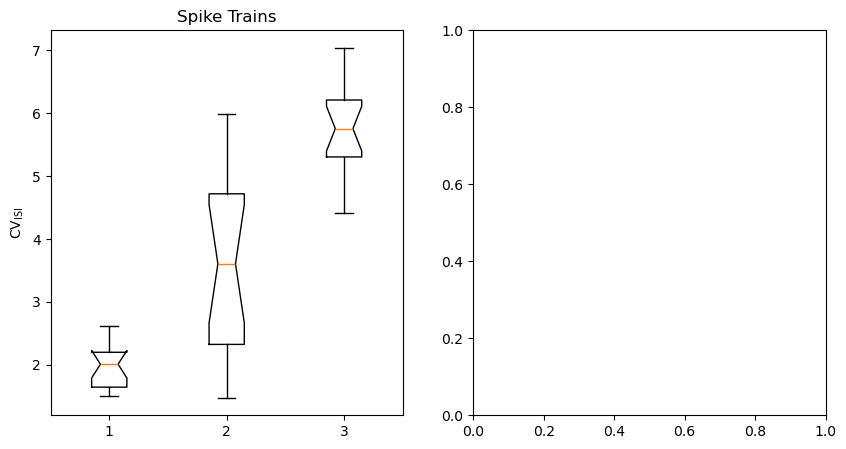

In [8]:
# Original states
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Spike Trains')
ax[0].set_ylabel(r'$\mathrm{CV_{ISI}}$')
box_plot(ax[0], [x.cv_isi() for x in spikes], [1, 2, 3])


In [11]:
all_cvs = []
for state in states:
    cv_states = []
    for i in range(state.matrix.shape[0]):
        cv_states.append(state.matrix[i, :].std() / state.matrix[i, :].mean())
    all_cvs.append(np.array(cv_states))

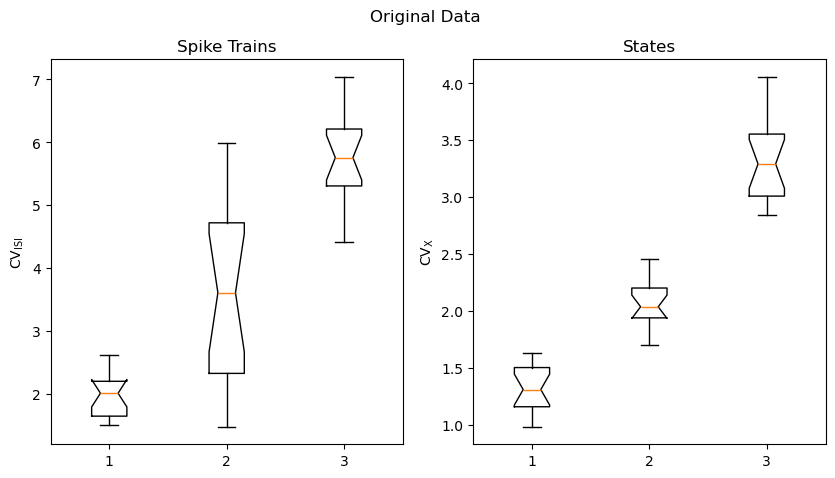

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Original Data")
ax[0].set_title('Spike Trains')
ax[0].set_ylabel(r'$\mathrm{CV_{ISI}}$')
ax[1].set_title('States')
ax[1].set_ylabel(r'$\mathrm{CV_{X}}$')
box_plot(ax[0], [x.cv_isi() for x in spikes], [1, 2, 3])
box_plot(ax[1], all_cvs, [1, 2, 3])
plt.savefig('./plots/comparison/spread-original.pdf')

In [18]:
single_well_embedding['PCA']['x_embd'].T.shape

(5, 300000)

In [15]:
len(labels)

300000

In [21]:
single_well_embedding['PCA']['x_embd'].T[:, np.where(np.array(labels) == 0)[0]]

0.05385827478130056

In [40]:
cvs1 = []
cvs1_single = []
for condition in [0, 1, 2]:
    state_vectors = single_well_embedding['PCA']['x_embd'].T[:, np.where(np.array(labels) == condition)[0]]
    cv_local = []
    for dim in range(state_vectors.shape[0]):
        cv_local.append(state_vectors[dim, :].std() / state_vectors[dim, :].mean())
    cvs1.append(np.array(np.abs(cv_local)))
    cvs1_single.append(state_vectors.std() / state_vectors.mean())

In [41]:
cvs2 = []
cvs2_single = []
for condition in [0, 1, 2]:
    state_vectors = single_well_embedding['tSNE']['x_embd'].T[:, np.where(np.array(labels) == condition)[0]]
    cv_local = []
    for dim in range(state_vectors.shape[0]):
        cv_local.append(state_vectors[dim, :].std() / state_vectors[dim, :].mean())
    cvs2.append(np.array(np.abs(cv_local)))
    cvs2_single.append(state_vectors.std() / state_vectors.mean())

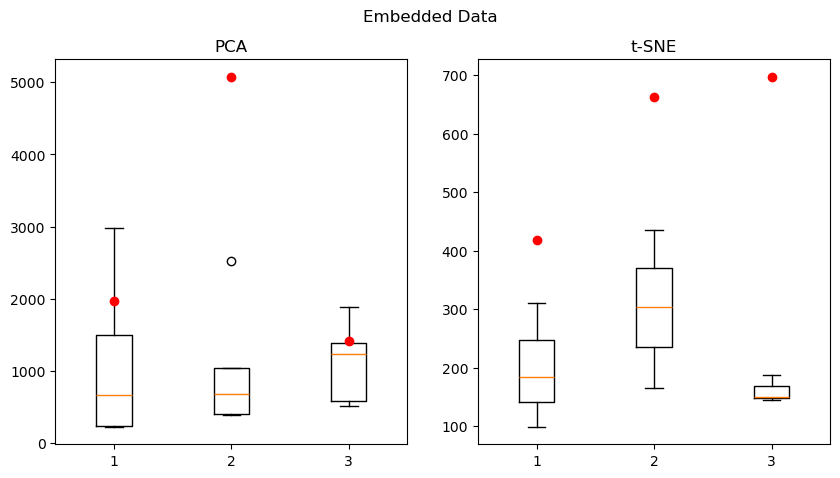

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Embedded Data")
ax[0].set_title('PCA')
# ax[0].set_ylabel(r'$\mathrm{CV_{X}}$')
ax[1].set_title('t-SNE')
# ax[1].set_ylabel(r'$\mathrm{CV_{X}$')
ax[0].boxplot(cvs1, positions=[1, 2, 3])
ax[0].plot([1, 2, 3], np.abs(cvs1_single), 'or')
ax[1].boxplot(cvs2, positions=[1, 2, 3])
ax[1].plot([1, 2, 3], np.abs(cvs2_single), 'or')
# violin_plot(ax[0], cvs1, [1, 2, 3], location=0)
# violin_plot(ax[1], cvs2, [1, 2, 3], location=0)
# ax[0].set_xlim([0, 4])
plt.savefig('./plots/comparison/embedded.pdf')